I'll refer to Gnedin et al. (2014) as "G14" hereafter.

In [1]:
import os
import math

# Third-party
from astropy.visualization import hist
from astropy.constants import G
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('apw-notebook')
%matplotlib inline
from scipy.integrate import odeint, quad
from scipy.stats import powerlaw, rv_continuous
from scipy.optimize import root, minimize
from scipy.special import gamma, gammainc
from scipy.interpolate import InterpolatedUnivariateSpline
import h5py

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

In [2]:
seed = 42 # for random numbers

In [3]:
m_tot = 5E10 # Msun
n_s = 2.2
r_s = 4. # kpc
z = 3. # formation epoch

### Cumulative mass for Sersic profile

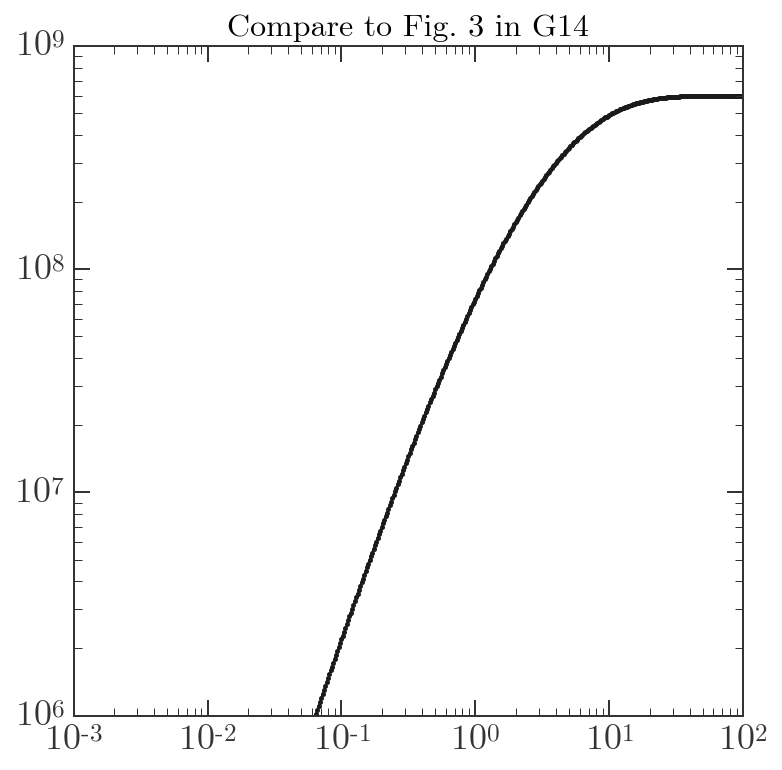

In [5]:
# Adapted from Oleg's C code (uncluster/src/gc_evolution.c)
# for MW, the parameters (r_s, n_s, etc.) don't evolve

def ell_model_Menc_grid(m_tot, n_s, r_s, n_grid=501):
    rmax = 99. # kpc - maximum radius
    an = 2 * n_s
    bn = 2. * n_s - 1./3. + 0.0098765/n_s + 0.0018/n_s**2
    
    argc = bn * (rmax/r_s) ** (1./n_s)
    gamnorm = gammainc(an, argc)
    
    r_ser = np.zeros(n_grid)
    m_ser = np.zeros(n_grid)
    for i in range(n_grid):
        r_ser[i] = r = 10**(-3. + i/100.)
        arg = bn * (r/r_s)**(1./n_s)
        m_ser[i] = gammainc(an, arg) / gamnorm
    
    return r_ser, m_ser

_rgrid, _mgrid = ell_model_Menc_grid(m_tot, n_s, r_s)

plt.figure(figsize=(6,6))
plt.loglog(_rgrid, _mgrid * m_tot * 0.012)
plt.xlim(1E-3, 1E2)
plt.ylim(1E6, 1E9)
plt.title("Compare to Fig. 3 in G14", fontsize=16)

In [32]:
def sample_radii(size=1):
    # Sample radii by inverting cumulative mass function (using interpolation)
    interp_func = InterpolatedUnivariateSpline(_mgrid, _rgrid, k=1)
    return interp_func(np.random.uniform(0, 1, size=size))

def mass_enc_stars(r):
    if r < 1E-3:
        return 1.
    interp_func = InterpolatedUnivariateSpline(_rgrid, _mgrid * m_tot, k=1)
    return interp_func(r)

---

In [12]:
N_gcs = 8000
t_evolve = 11.5*u.Gyr

## Sample masses from power law

In [13]:
def sample_masses(M_min, M_max, size=1):
    M_min = M_min.to(u.Msun).value
    M_max = M_max.to(u.Msun).value
    
    class MassFunction(rv_continuous):
        def _pdf(self, x):
            return x**-2 / (1/self.a - 1/self.b)
        
    return MassFunction(a=M_min, b=M_max).rvs(size=size) * u.Msun

In [16]:
np.random.seed(seed)
gc_masses = sample_masses(M_min=1E4*u.Msun, M_max=1E7*u.Msun, size=N_gcs)
gc_r = sample_radii(size=N_gcs) * u.kpc

Compare with Figure 2 in G14

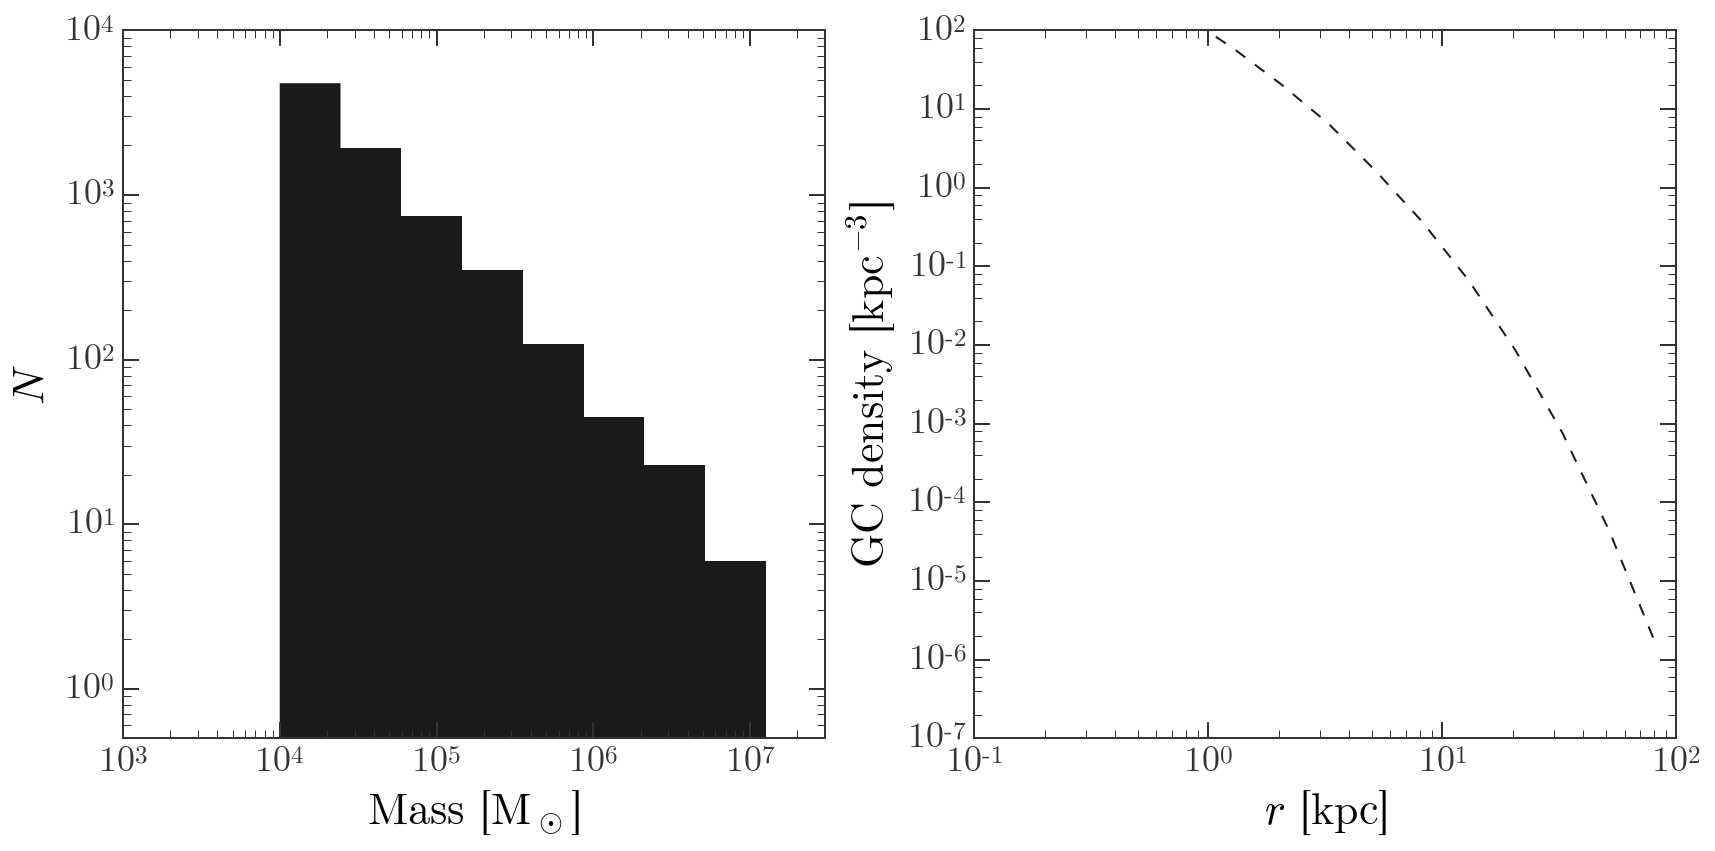

In [18]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].hist(gc_masses, bins=np.logspace(4,7.1,9));
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(1E3, 3E7)
axes[0].set_ylim(5E-1, 1E4)
axes[0].set_xlabel(r"Mass [${\rm M}_\odot$]")
axes[0].set_ylabel(r"$N$")

bins = np.logspace(-1.,2.,16)
H,_ = np.histogram(gc_r, bins=bins)

V = 4/3*np.pi*(bins[1:]**3 - bins[:-1]**3)
bin_cen = (bins[1:]+bins[:-1])/2.
axes[1].plot(bin_cen, H/V, ls='--', marker=None)

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(1E-1, 1E2)
axes[1].set_ylim(1E-7, 1E2)
axes[1].set_xlabel(r"$r$ [kpc]")
axes[1].set_ylabel('GC density [kpc$^{-3}$]')

fig.tight_layout()

## Compute disruption times

In [ ]:
# def P(r, pot):
#     return 41.4 * (r.to(u.kpc).value) / (circ_vel(r, pot).to(u.km/u.s).value)
    
# def t_tid(r, M, pot, α=2/3.):
#     """ Tidal disruption timescale """
#     return 10*u.Gyr * (M / (2E5*u.Msun))**α * P(r, pot)

# def t_iso(M):
#     """ Isolation disruption timescale (2-body evaporation)"""
#     return 17*u.Gyr * (M / (2E5*u.Msun))

# def t_df(r, M, pot, f_e=0.5):
#     return 0.45*u.Gyr * (r.to(u.kpc).value)**2 * (circ_vel(r, pot).to(u.km/u.s).value) * (M/(1E5*u.Msun))**-1 * f_e

# def F(y, t):
#     M,r2 = y
    
#     r = np.sqrt(r2)
#     min_t = np.min([t_tid(r*u.kpc, M*u.Msun, pot).to(u.Gyr).value, 
#                     t_iso(M*u.Msun).to(u.Gyr).value], axis=0)
    
#     M_dot = -M / min_t
#     r2_dot = -r2 / t_df(r*u.kpc, M*u.Msun, pot).to(u.Gyr).value
    
#     return [float(M_dot), float(r2_dot)]

In [ ]:
_G = G.decompose(galactic).value

In [22]:
kms = 2.07E-3
Mh = 1E12 # Msun
rs_h = 20. # kpc
def _circ_vel_kms(r):
    Mstar = mass_enc_stars(r)
    Mhalo = Mh*(math.log(1.+r/rs_h) - r/rs_h/(1.+r/rs_h))
    return math.sqrt((Mstar + Mhalo)/r) * kms

In [23]:
def P(r):
    return 41.4 * r / _circ_vel_kms(r)
    
def t_tid(r, M, α=2/3.):
    """ Tidal disruption timescale """
    return 10. * (M / 2E5)**α * P(r)

def t_iso(M):
    """ Isolation disruption timescale (2-body evaporation)"""
    return 17. * (M / 2E5)

def t_df(r, M, f_e=0.5):
    return 0.45 * r*r * _circ_vel_kms(r) * (M/1E5)**-1 * f_e

def F(y, t):
    M,r2 = y
    
    r = np.sqrt(r2)
    min_t = np.min([t_tid(r, M), 
                    t_iso(M)], axis=0)
    
    M_dot = -M/min_t
    r2_dot = -r2/t_df(r, M)
    
    return [float(M_dot), float(r2_dot)]

In [33]:
fname = "../output/gc-evolve.h5"
if not os.path.exists(fname) or True:
    t_grid = np.linspace(0., t_evolve.value, 4096)

    with h5py.File(fname, "w") as f:
        f.create_dataset('time', data=t_grid)
        f.create_group('mass')
        f.create_group('radius')

        f['time'].attrs['unit'] = 'Gyr'
        f['mass'].attrs['unit'] = 'solMass'
        f['radius'].attrs['unit'] = 'kpc'

        for i,_r,_M in zip(range(N_gcs), gc_r.to(u.kpc).value, gc_masses.to(u.Msun).value):
            if (i % 1000) == 0:
                print(i)

            M_r2 = odeint(F, [_M, _r**2], t=t_grid)
            f['mass'].create_dataset(str(i), data=M_r2[:,0])
            f['radius'].create_dataset(str(i), data=np.sqrt(M_r2[:,1]))

0


/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in sqrt


1000
2000
3000
4000
5000
6000
7000


In [34]:
t_disrupt = np.zeros(N_gcs)
final_r = np.zeros(N_gcs)
final_m = np.zeros(N_gcs)
did_disrupt = np.zeros(N_gcs).astype(bool)
with h5py.File("../output/gc-evolve.h5", "r") as f:
    for i in range(N_gcs):
        _mass = f['mass/{}'.format(i)][:]
        _radius = f['radius/{}'.format(i)][:]
        
        if np.any(np.isnan(_mass)) or np.any(_mass < 0.):
            t_disrupt[i] = f['time'][np.isfinite(_mass) & (_mass >= 0)][-1]
            final_r[i] = _radius[np.isfinite(_mass) & (_mass >= 0)][-1]
            final_m[i] = 0.
            did_disrupt[i] = True
            
        else:
            t_disrupt[i] = np.nan
            final_r[i] = _radius[-1]
            final_m[i] = _mass[-1]
            did_disrupt[i] = False
            
    t_disrupt = t_disrupt*u.Unit(f['time'].attrs['unit'])
    final_r = final_r*u.Unit(f['radius'].attrs['unit'])

/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater_equal
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater_equal


In [35]:
print("{} did not disrupt".format(N_gcs-did_disrupt.sum()))
print("{:.0%}".format(did_disrupt.sum() / N_gcs))

290 did not disrupt
96%


TODO: what the hell is up with the spikes??? obviously something in the above is wrong

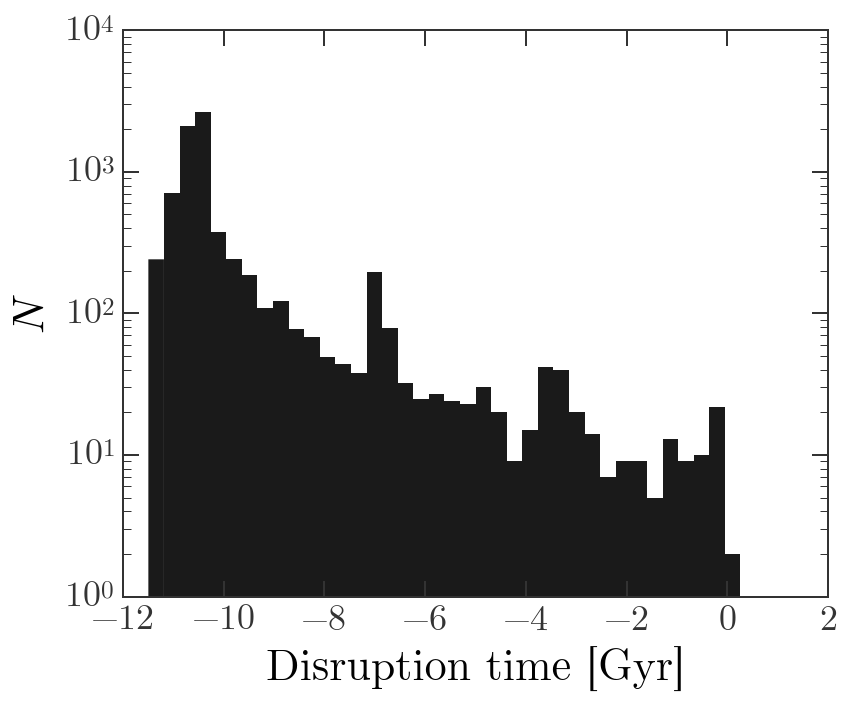

In [38]:
plt.figure(figsize=(6,5))
hist((t_disrupt - t_evolve)[did_disrupt], bins='scott')
plt.yscale('log')
plt.xlabel('Disruption time [Gyr]')
plt.ylabel('$N$')
plt.tight_layout()
# pl.savefig("/Users/adrian/projects/how-many-streams/plots/t_disrupt.pdf")

TODO: now i have disruption times, masses, radii, and mass-loss rates I can run simulations with some eccentricity distribution

---

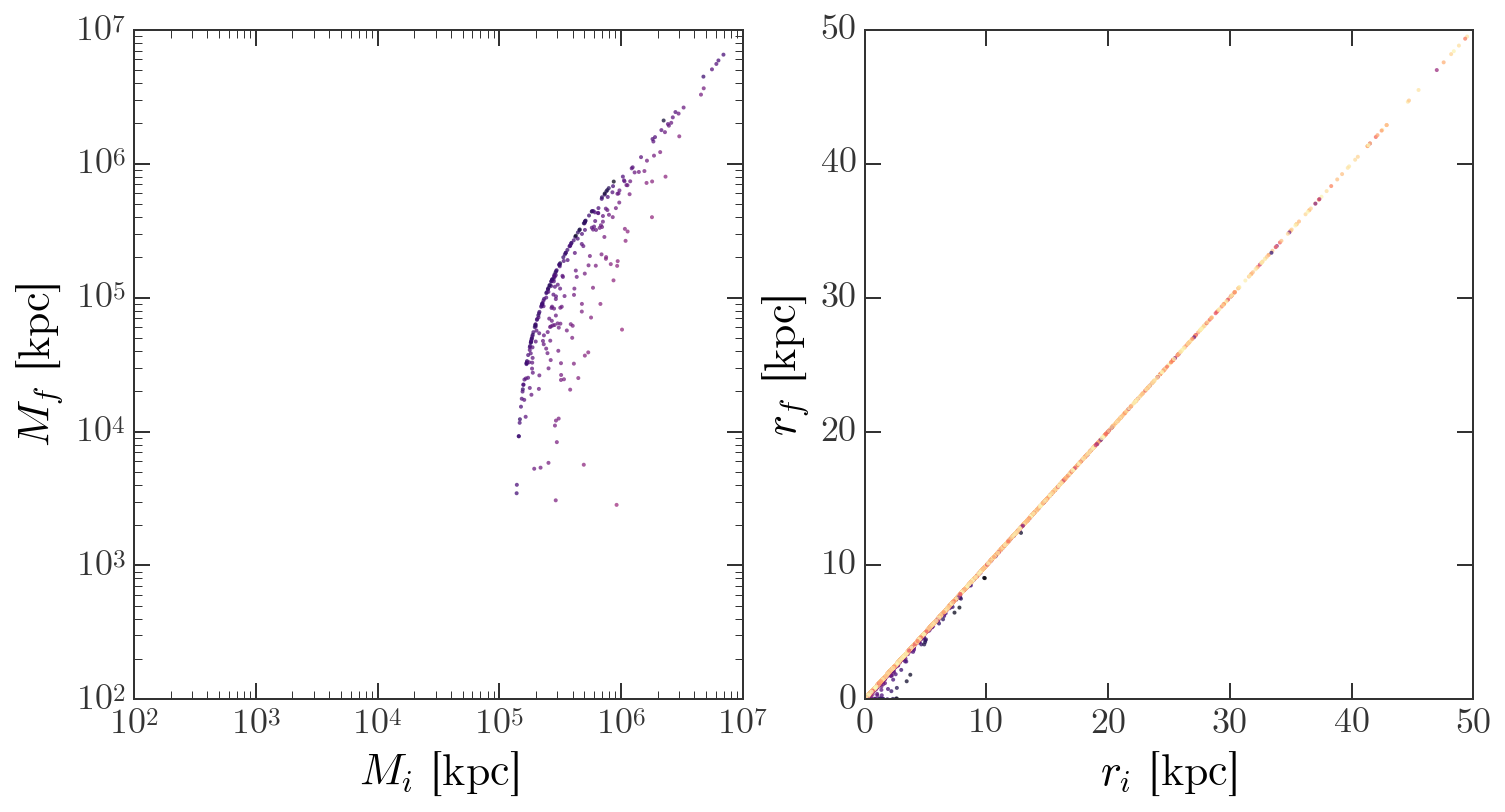

In [41]:
fig,axes = plt.subplots(1,2,figsize=(12,6))

axes[0].scatter(gc_masses, final_m, c=np.log10(gc_r.value), cmap='magma_r', alpha=0.75, s=4)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(1E2,1E7)
axes[0].set_ylim(1E2,1E7)
axes[0].set_xlabel('$M_i$ [kpc]')
axes[0].set_ylabel('$M_f$ [kpc]')

axes[1].scatter(gc_r, final_r, c=np.log10(gc_masses.value), cmap='magma_r', alpha=0.75, s=4)
axes[1].set_xlim(0,50)
axes[1].set_ylim(0,50)
axes[1].set_xlabel('$r_i$ [kpc]')
axes[1].set_ylabel('$r_f$ [kpc]')

In [42]:
from astropy.io import fits
import astropy.coordinates as coord

In [43]:
harris_tbl = fits.getdata("../data/harris-gc-catalog.fits", 1)

In [44]:
harris_c = coord.SkyCoord(ra=harris_tbl['RA']*u.degree, dec=harris_tbl['DEC']*u.degree,
                          distance=harris_tbl['HELIO_DISTANCE']*u.kpc)
harris_gc_dist = harris_c.transform_to(coord.Galactocentric).represent_as(coord.PhysicsSphericalRepresentation).r

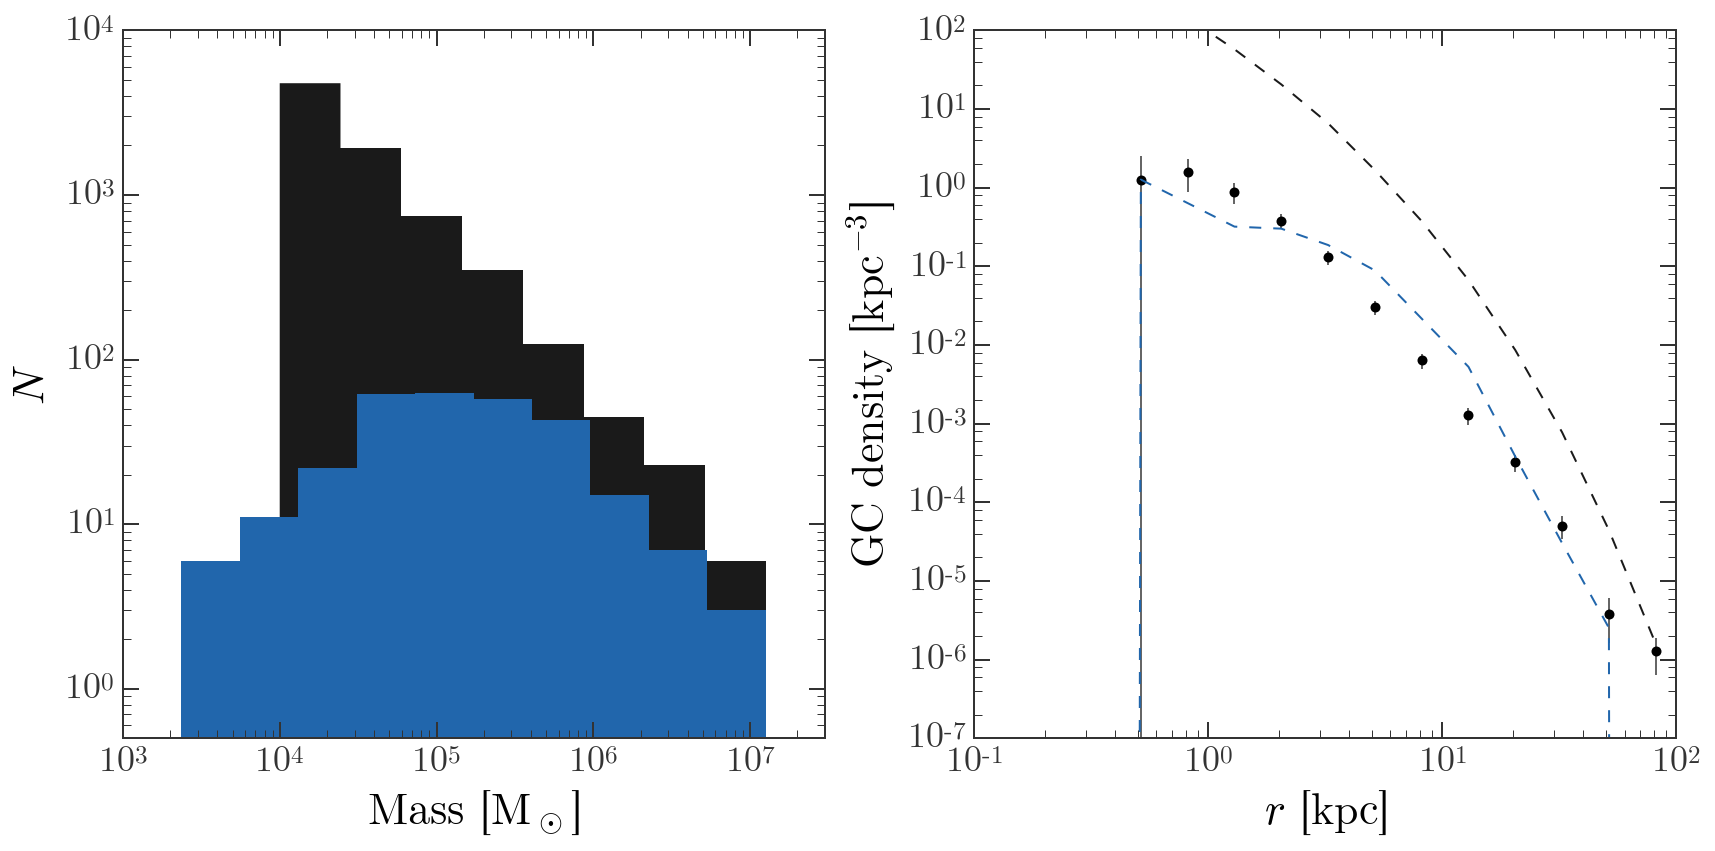

In [46]:
fig,axes = plt.subplots(1,2,figsize=(12,6))

axes[0].hist(gc_masses, bins=np.logspace(4,7.1,9));
axes[0].hist(final_m[~did_disrupt], bins=np.logspace(3,7.1,12));

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(1E3, 3E7)
axes[0].set_ylim(5E-1, 1E4)
axes[0].set_xlabel(r"Mass [${\rm M}_\odot$]")
axes[0].set_ylabel(r"$N$")

bins = np.logspace(-1.,2.,16)
H,_ = np.histogram(gc_r, bins=bins)
data_H,_ = np.histogram(harris_gc_dist, bins=bins)

V = 4/3*np.pi*(bins[1:]**3 - bins[:-1]**3)
bin_cen = (bins[1:]+bins[:-1])/2.
axes[1].plot(bin_cen, H/V, ls='--', marker=None)
axes[1].errorbar(bin_cen, data_H/V, np.sqrt(data_H)/V, 
                 color='k', marker='o', ecolor='#666666', linestyle='none')

H_f,_ = np.histogram(final_r[~did_disrupt], bins=bins)
axes[1].plot(bin_cen, H_f/V, ls='--', marker=None)

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(1E-1, 1E2)
axes[1].set_ylim(1E-7, 1E2)
axes[1].set_xlabel(r"$r$ [kpc]")
axes[1].set_ylabel('GC density [kpc$^{-3}$]')

fig.tight_layout()

# fig.savefig("/Users/adrian/projects/uncluster/plots/GC-mass-radius.pdf")

In [51]:
(gc_r[~did_disrupt] > 5.*u.kpc).sum()

200